In [1]:
from training.perceiver import*
from training.utils import*
from training.losses import*
from training.VIT import*
from training.ResNet import*
from collections import defaultdict
from training import*

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

import torch
import numpy as np
from torch import nn, einsum
import torch.nn.functional as F
import einops as einops
from einops import rearrange, repeat
from einops.layers.torch import Reduce

import matplotlib.pyplot as plt

from configilm import util
util.MESSAGE_LEVEL = util.MessageLevel.INFO  # use INFO to see all messages


from configilm.extra.DataSets import BENv2_DataSet
from configilm.extra.DataModules import BENv2_DataModule

torch.manual_seed(0)

In [2]:
mode="validation"

In [3]:
def prepare_BENv2(mode=None,max_len=None):
    dico_paths={"images_lmdb":"data/Encoded-BigEarthNet/",
    "metadata_parquet":"data/Encoded-BigEarthNet/metadata.parquet",
    "metadata_snow_cloud_parquet":"data/Encoded-BigEarthNet/metadata_for_patches_with_snow_cloud_or_shadow.parquet"}

    if max_len!=None:
        return BENv2_DataSet.BENv2DataSet(data_dirs=dico_paths, img_size=(14, 120, 120),split=mode,max_len=max_len)

    df=open_parquet(dico_paths["metadata_parquet"])
    return BENv2_DataSet.BENv2DataSet(data_dirs=dico_paths, img_size=(14, 120, 120),split=mode),df



In [4]:
def create_datasets(name,trans_conf,sizes=(2,2,2),max_len=None):

   
    mode="train"
    ds,df=prepare_BENv2(max_len=max_len)
    idxs,_=get_tiny_dataset(ds,df,MAX_IDs=sizes[0],mode=mode)
    stats=create_dataset(idxs, ds, name=name, mode=mode, trans_config=trans_conf,stats=None)

    mode="validation"
    ds,_=prepare_BENv2(max_len=max_len)
    idxs,_=get_tiny_dataset(ds,df,MAX_IDs=sizes[1],mode=mode)
    create_dataset(idxs, ds, name=name, mode=mode,trans_config=trans_conf,stats=stats)

    mode="test"
    ds,_=prepare_BENv2(max_len=max_len)
    idxs,_=get_tiny_dataset(ds,df,MAX_IDs=sizes[2],mode=mode)
    create_dataset(idxs, ds, name=name, mode=mode,trans_config=trans_conf,stats=stats)

    

In [5]:
bands_yaml="./data/Tiny_BigEarthNet/bands.yaml"
configs_dataset="./data/Tiny_BigEarthNet/configs_dataset_loader.yaml"

test_conf= transformations_config(bands_yaml,configs_dataset,path_imgs_config="./data/Tiny_BigEarthNet/",name_config="loader")

create_datasets("loader",test_conf,sizes=(10,10,10))

[INFO]    Loading BEN data for None...
[INFO]        480038 patches indexed
[INFO]        480038 pre-filtered patches indexed
[INFO]        480038 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 549488 labels
[INFO]    Loaded 549488 keys
[INFO]    Loaded mapping created
[INFO]    Opening LMDB environment ...
summary dico stats
{18: 10, 12: 10, 8: 10, 6: 10, 1: 10, 11: 10, 15: 10, 9: 10, 14: 10, 13: 10, 3: 10, 16: 10, 17: 10, 0: 10, 5: 10, 4: 10, 10: 10, 7: 10, 2: 10}
[INFO]    Loading BEN data for None...
[INFO]        480038 patches indexed
[INFO]        480038 pre-filtered patches indexed
[INFO]        480038 filtered patches indexed
[INFO]    Merged metadata with snow/cloud metadata
[INFO]    Loaded 549488 labels
[INFO]    Loaded 549488 keys
[INFO]    Loaded mapping created
[INFO]    Opening LMDB environment ...
summary dico stats
{15: 10, 12: 10, 6: 10, 8: 10, 11: 10, 18: 10, 1: 10, 9: 10, 13: 10, 5: 10, 0: 10, 3: 10, 17: 10, 16: 10, 14:

In [76]:
data_module=Tiny_BigEarthNetDataModule( "./data/Tiny_BigEarthNet/regular", batch_size=1, num_workers=4,trans_config=test_conf,model="Atomiser")

data_module.setup()
# Prepare dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

In [77]:
batch_test=None
for batch in train_loader:
    batch_test=batch[0]
    break


In [78]:
batch_test.shape

torch.Size([1, 53900, 28])

In [79]:
idx=1
img=torch.stack([batch_test[idx,5],batch_test[idx,4],batch_test[idx,3]],dim=-1)
img.shape

IndexError: index 1 is out of bounds for dimension 0 with size 1

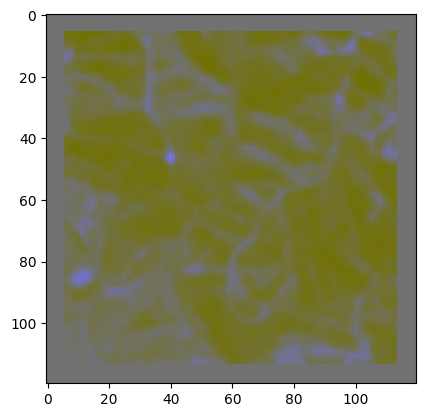

In [10]:
plt.imshow(normalize(img))

In [ ]:
scp -P 30370 -r ./Documents/Per-Sent-1-2/data/Tiny_BigEarthNet/regular_*.h5 root@78.60.214.72:/home/Per-Sent-1-2/data/Tiny_BigEarthNet/
